# Part 5, Model 2A NN: Glaucoma Detection using a neural network on the fundus images of the eye + selected patient details.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-04-06 15:06:54.722129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 15:06:54.722195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 15:06:54.723503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 15:06:54.732274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 15:06:55.580211: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data['fundus_oc_seg'].dtype

dtype('O')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [9]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


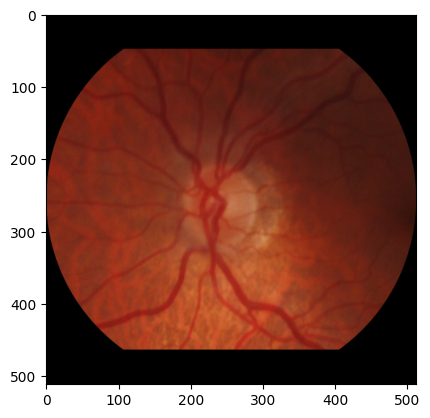

In [10]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

viewFundus(data['fundus'][12044])

In [11]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [13]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

data = data.dropna(axis=1, how='all')

data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

for col in ['gender', 'eye']:
    if col in data.columns:
        mode = data[col].mode()[0]
        data[col] = data[col].fillna(mode)

numerical_data = data.select_dtypes(include=[np.number])

rf_regressor = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    n_jobs=-1,
    random_state=None
)

imp = IterativeImputer(
    estimator=rf_regressor,
    max_iter=10,
    random_state=None
)

numerical_data_imputed = imp.fit_transform(numerical_data)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

integer_columns = ['types', 'isColor', 'gender', 'eye', 'age']
for col in integer_columns:
    if col in numerical_data_imputed.columns:
        numerical_data_imputed[col] = numerical_data_imputed[col].round().astype('Int64')

non_numerical_data = data.select_dtypes(exclude=[np.number])
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[data.index]

print("Shape of imputed data:", data_imputed.shape)

Shape of imputed data: (12449, 47)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [14]:
print(data_imputed.describe())

          types  isColor    gender       age       eye           sbp  \
count   12449.0  12449.0   12449.0   12449.0   12449.0  12449.000000   
mean   0.372239      1.0  0.985059   59.1715   0.77444    200.014824   
std    0.505039      0.0  0.121322  7.880865  0.417968     64.247198   
min        -1.0      1.0       0.0       1.0       0.0    107.000000   
25%         0.0      1.0       1.0      58.0       1.0    131.866667   
50%         0.0      1.0       1.0      62.0       1.0    181.706667   
75%         1.0      1.0       1.0      62.0       1.0    261.760000   
max         1.0      1.0       1.0      91.0       1.0    412.000000   

                dbp            hr           iop          vcdr  ...  \
count  12449.000000  12449.000000  12449.000000  12449.000000  ...   
mean      81.611265     69.182273     16.181918      0.584780  ...   
std        5.035243      6.003043      1.041941      0.123885  ...   
min       47.000000     51.000000      8.000000      0.161000  ...   
2

In [15]:
data_imputed[["eye"]].value_counts()

eye
1      9641
0      2808
Name: count, dtype: int64

In [16]:
data = data_imputed

data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0,1,1,58,0,262.653333,74.640000,62.446667,16.780000,0.448772,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,60,1,216.153333,84.146667,67.473333,16.780000,0.689866,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,1,66,1,144.673333,87.193333,71.720000,17.426667,0.684691,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,1,70,0,147.926667,87.500000,71.526667,17.426667,0.698690,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,1,45,1,283.513333,79.400000,64.093333,16.606667,0.585584,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0,1,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0,1,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0,1,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0,1,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data = data[
    
    (data['fundus'].notnull()) & (data['types'] != -1)
    
]

fundus_subset = data[['types', 'fundus', 'names', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   types     12316 non-null  object 
 1   fundus    12316 non-null  object 
 2   names     12316 non-null  object 
 3   gender    12316 non-null  Int64  
 4   age       12316 non-null  Int64  
 5   eye       12316 non-null  Int64  
 6   sbp       12316 non-null  float64
 7   dbp       12316 non-null  float64
 8   hr        12316 non-null  float64
 9   iop       12316 non-null  float64
 10  vcdr      12316 non-null  float64
 11  cdr_avg   12316 non-null  float64
 12  combined  12316 non-null  object 
dtypes: Int64(3), float64(6), object(4)
memory usage: 1.4+ MB


/tmp/ipykernel_380/1473027726.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_380/1473027726.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_380/1473027726.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [18]:
fundus_subset['types'].value_counts()

types
0    7549
1    4767
Name: count, dtype: int64

In [19]:
fundus_subset

,types,fundus,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,1,58,0,262.653333,74.640000,62.446667,16.780000,0.448772,0.579750,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,1,60,1,216.153333,84.146667,67.473333,16.780000,0.689866,0.581300,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,1,66,1,144.673333,87.193333,71.720000,17.426667,0.684691,0.674633,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,1,70,0,147.926667,87.500000,71.526667,17.426667,0.698690,0.676283,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,1,45,1,283.513333,79.400000,64.093333,16.606667,0.585584,0.427717,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0,/full-fundus/FIVES-396.png,FIVES-396,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,FIVES-396.png
12445,0,/full-fundus/FIVES-397.png,FIVES-397,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,FIVES-397.png
12446,0,/full-fundus/FIVES-398.png,FIVES-398,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,FIVES-398.png
12447,0,/full-fundus/FIVES-399.png,FIVES-399,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,FIVES-399.png


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.10
val_percentage_from_train = 0.05 

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 4767
this is the healthy eyes count 7549

Total fundus images to be used: 12316

Train set size: 10529
Validation set size: 555
Test set size: 1232


In [21]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  10529
Test Size:  1232


In [22]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-06 15:08:39.476175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 15:08:39.510328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 15:08:39.510671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [23]:
train

,types,fundus,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined
10440,1,/full-fundus/EyePACS-Glaucoma-2150.png,EyePACS-Glaucoma-2150,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-2150.png
9773,1,/full-fundus/EyePACS-Glaucoma-1482.png,EyePACS-Glaucoma-1482,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-1482.png
10147,1,/full-fundus/EyePACS-Glaucoma-1856.png,EyePACS-Glaucoma-1856,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-1856.png
10088,1,/full-fundus/EyePACS-Glaucoma-1797.png,EyePACS-Glaucoma-1797,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-1797.png
7804,0,/full-fundus/G1020-533.png,G1020-533,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,G1020-533.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,1,/full-fundus/OIA-ODIR-TRAIN-769.png,OIA-ODIR-TRAIN-769,1,54,1,236.673333,85.893333,71.193333,16.673333,0.705459,0.564233,OIA-ODIR-TRAIN-769.png
11936,0,/full-fundus/PAPILA-376.png,PAPILA-376,0,62,1,181.706667,85.320000,68.446667,16.913333,0.752215,0.653250,PAPILA-376.png
3050,0,/full-fundus/OIA-ODIR-TRAIN-1763.png,OIA-ODIR-TRAIN-1763,1,75,1,155.873333,78.433333,68.246667,15.613333,0.559995,0.732550,OIA-ODIR-TRAIN-1763.png
781,0,/full-fundus/OIA-ODIR-TEST-ONLINE-329.png,OIA-ODIR-TEST-ONLINE-329,1,62,0,194.433333,85.180000,68.213333,16.833333,0.736287,0.634833,OIA-ODIR-TEST-ONLINE-329.png


In [24]:
val

,types,fundus,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined
12293,0,/full-fundus/FIVES-245.png,FIVES-245,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,FIVES-245.png
2443,0,/full-fundus/OIA-ODIR-TRAIN-1121.png,OIA-ODIR-TRAIN-1121,1,56,1,287.753333,77.673333,63.826667,16.393333,0.547581,0.536517,OIA-ODIR-TRAIN-1121.png
6865,1,/full-fundus/DRISHTI-GS1-train-44.png,DRISHTI-GS1-train-44,1,57,1,223.020000,82.140000,74.353333,15.473333,0.683080,0.602500,DRISHTI-GS1-train-44.png
12356,0,/full-fundus/FIVES-308.png,FIVES-308,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,FIVES-308.png
1817,0,/full-fundus/OIA-ODIR-TRAIN-478.png,OIA-ODIR-TRAIN-478,1,67,0,143.573333,87.280000,71.313333,17.386667,0.696205,0.672000,OIA-ODIR-TRAIN-478.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9956,1,/full-fundus/EyePACS-Glaucoma-1665.png,EyePACS-Glaucoma-1665,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-1665.png
3074,0,/full-fundus/OIA-ODIR-TRAIN-1787.png,OIA-ODIR-TRAIN-1787,1,49,1,283.580000,79.373333,64.033333,16.606667,0.581783,0.456667,OIA-ODIR-TRAIN-1787.png
4254,0,/full-fundus/OIA-ODIR-TRAIN-3011.png,OIA-ODIR-TRAIN-3011,1,51,1,263.406667,79.320000,63.973333,16.660000,0.563981,0.509400,OIA-ODIR-TRAIN-3011.png
2506,0,/full-fundus/OIA-ODIR-TRAIN-1186.png,OIA-ODIR-TRAIN-1186,1,69,0,147.940000,87.480000,71.540000,17.420000,0.698999,0.675383,OIA-ODIR-TRAIN-1186.png


In [25]:
test

,types,fundus,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined
5101,1,/full-fundus/ORIGA-556.png,ORIGA-556,1,62,0,134.733333,87.073333,75.206667,16.333333,0.703000,0.664567,ORIGA-556.png
5244,0,/full-fundus/sjchoi86-HRF-49.png,sjchoi86-HRF-49,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,sjchoi86-HRF-49.png
11812,1,/full-fundus/PAPILA-252.png,PAPILA-252,1,72,1,150.006667,72.960000,66.473333,10.266667,0.530399,0.833800,PAPILA-252.png
4324,0,/full-fundus/OIA-ODIR-TRAIN-3083.png,OIA-ODIR-TRAIN-3083,1,71,0,146.060000,86.940000,71.700000,17.406667,0.673384,0.679117,OIA-ODIR-TRAIN-3083.png
8413,1,/full-fundus/EyePACS-Glaucoma-122.png,EyePACS-Glaucoma-122,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-122.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,0,/full-fundus/OIA-ODIR-TRAIN-1255.png,OIA-ODIR-TRAIN-1255,1,73,1,153.040000,88.893333,74.340000,14.966667,0.616593,0.706433,OIA-ODIR-TRAIN-1255.png
5869,0,/full-fundus/BEH-273.png,BEH-273,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,BEH-273.png
6394,0,/full-fundus/REFUGE1-train-164.png,REFUGE1-train-164,1,58,1,261.760000,74.780000,62.546667,16.786667,0.375317,0.567433,REFUGE1-train-164.png
10133,1,/full-fundus/EyePACS-Glaucoma-1842.png,EyePACS-Glaucoma-1842,1,62,1,131.866667,86.026667,76.293333,15.400000,0.674020,0.689150,EyePACS-Glaucoma-1842.png


In [26]:
train_fundus = train['fundus'].tolist()
val_fundus = val['fundus'].tolist()
test_fundus = test['fundus'].tolist()

print("Number of similar images in train and val sets:", len(set(train_fundus).intersection(val_fundus)))
print("Number of similar images in train and test sets:", len(set(train_fundus).intersection(test_fundus)))
print("Number of similar images in val and test sets:", len(set(val_fundus).intersection(test_fundus))) 

Number of similar images in train and val sets: 0
Number of similar images in train and test sets: 0
Number of similar images in val and test sets: 0


In [27]:
train[['types']].value_counts()

types
0        6454
1        4075
Name: count, dtype: int64

In [28]:
val[['types']].value_counts()

types
0        340
1        215
Name: count, dtype: int64

In [29]:
test[['types']].value_counts()

types
0        755
1        477
Name: count, dtype: int64

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-04-06 15:08:39.659549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 15:08:39.660040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 15:08:39.660384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 15:08:40.062443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 15:08:40.062852: I external/local_xla/xla/stream_executor

Found 10529 validated image filenames belonging to 2 classes.
Found 555 validated image filenames belonging to 2 classes.
Found 1232 validated image filenames belonging to 2 classes.


In [31]:
# funnction to get a combined generator for images and numerical features
def combined_generator(generators, num_features, labels, batch_size):

    while True:

        # get the next batch of images
        images_batch = [next(gen)[0] for gen in generators]

        # get the index
        idx = (generators[0].batch_index - 1) * generators[0].batch_size

        # get the batch index
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))

        # get the batch of numerical features
        num_features_batch = np.array(num_features[batch_index], dtype=np.float32)
        
        # get the batch of labels
        labels_batch = np.array(labels[batch_index], dtype=np.float32)

        # yield the images and numerical features
        yield images_batch + [num_features_batch], labels_batch


num_features = train[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']].astype(np.float32).values
labels = train['types'].values.astype(np.float32)

# create a combined generator to train the model
train_generator = combined_generator(
    [trainGen],
    num_features,
    labels,
    batchSize
)

val_features = val[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']].astype(np.float32).values
val_labels = val['types'].values.astype(np.float32)

# create a combined generator to validate the model
val_generator = combined_generator(
    [valGen],
    val_features,
    val_labels,
    batchSize
)

test_features = test[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']].astype(np.float32).values
test_labels = test['types'].values.astype(np.float32)

# create a combined generator to test the model
test_evaluation_generator = combined_generator(
    [testGen],
    test_features,
    test_labels,
    batchSize
)


In [32]:
mock_batch_data, mock_batch_labels = next(train_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Numerical batch shape:", mock_batch_data[1].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 9)
Label batch shape: (1,)


In [33]:
from keras.applications import MobileNetV3Small
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate

# Define the input shape
image_input_shape = (224, 224, 3)

# Define the number of features
num_features = 9

# Load the MobileNetV3 model with pre-trained weights
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=image_input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define the input image layer
fundus_input = Input(shape=image_input_shape, name='fundus_input')

# Pass the input image through the base model
fundus_features = base_model(fundus_input)

# Global average pooling layer to reduce the spatial dimensions
fundus_features = GlobalAveragePooling2D()(fundus_features)

# Define the input for numerical features
num_features_input = Input(shape=(num_features,), name='numerical_input')

# Concatenate the fundus and numerical features
combined_features = concatenate([fundus_features, num_features_input])

# Dense layers with 256 and 128 units and ReLU activation
x = Dense(256, activation='relu')(combined_features)
x = Dense(128, activation='relu')(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[fundus_input, num_features_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fundus_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['fundus_input[0][0]']        
 al)                                                                                              
                                                                                                  
 global_average_pooling2d (  (None, 576)                  0         ['MobilenetV3small[0][0]']    
 GlobalAveragePooling2D)                                                                          
                                                                                              

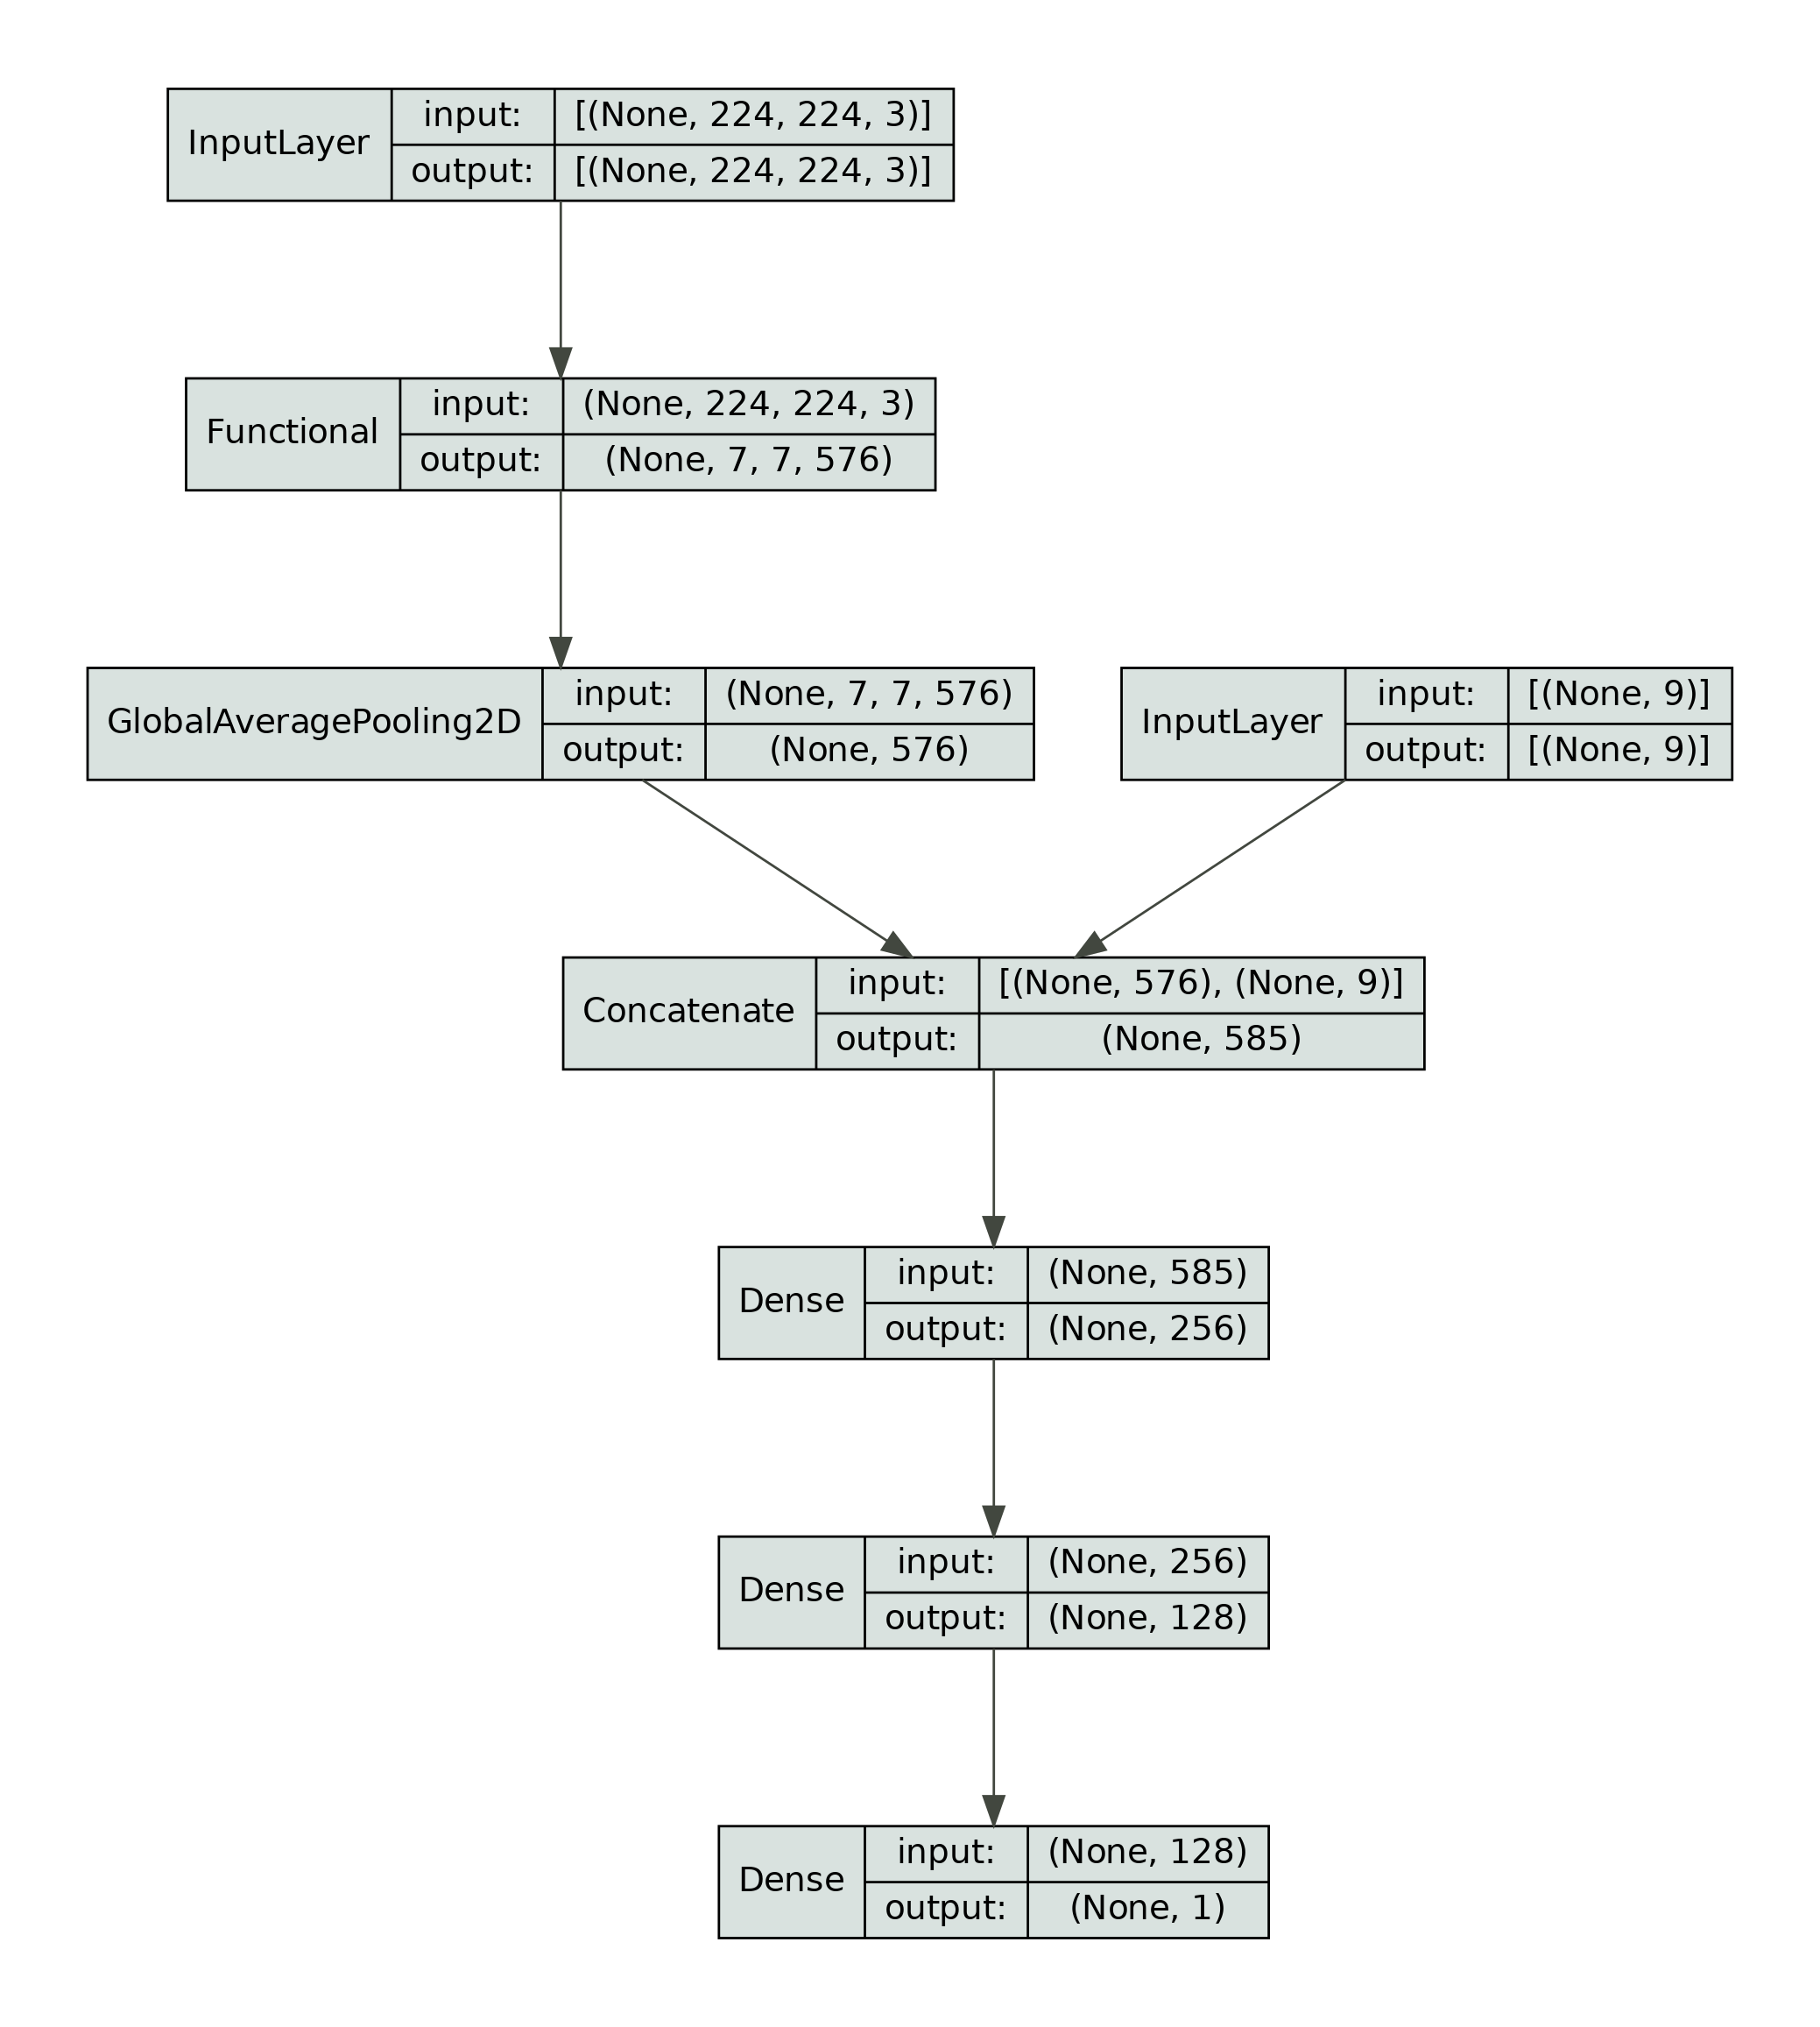

In [34]:
from keras.utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(
    model,
    show_shapes=True,
    show_layer_names=False,
    rankdir='TB',
    dpi=200
)

for n in dot.get_nodes():

    n.set('style', 'filled')
    n.set('fillcolor', '#D9E2DF')
    n.set('fontname', 'Helvetica')

for e in dot.get_edges():

    e.set('color', '#42473F')
    e.set('arrowsize', '1.2')

dot.set_graph_defaults(
    bgcolor='#FFFFFF',
    pad='0.5',
    ranksep='1.0',
    nodesep='0.5'
)
dot.set_node_defaults(
    shape='box',
    style='filled',
    fillcolor='#D9E2DF',
    height='0.5',
    width='0.5',
    fontsize='10',
    color='#666666'
)
dot.set_edge_defaults(
    color='#D9E2DF',
    arrowsize='0.8',
    fontsize='10'
)

dot.write_png('architectures/model_2A_Architecture.png')
Image('architectures/model_2A_Architecture.png')

In [35]:
history = model.fit(

    x=train_generator,
    epochs=10,
    steps_per_epoch=len(trainGen),
    validation_data=val_generator,
    validation_steps=len(valGen)
)

Epoch 1/10


2024-04-06 15:09:06.374393: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-06 15:09:06.540603: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 15:09:07.416992: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 15:09:08.084559: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1c44167ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 15:09:08.084623: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-04-06 15:09:08.094498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712401748.218064   14840 devic

10529/10529 [==============================] - 207s 19ms/step - loss: 0.2633 - accuracy: 0.9078 - val_loss: 0.2040 - val_accuracy: 0.8865
Epoch 2/10
10529/10529 [==============================] - 165s 16ms/step - loss: 0.1797 - accuracy: 0.9411 - val_loss: 0.1369 - val_accuracy: 0.9495
Epoch 3/10
10529/10529 [==============================] - 168s 16ms/step - loss: 0.1643 - accuracy: 0.9473 - val_loss: 0.1413 - val_accuracy: 0.9495
Epoch 4/10
10529/10529 [==============================] - 166s 16ms/step - loss: 0.1526 - accuracy: 0.9502 - val_loss: 0.1425 - val_accuracy: 0.9441
Epoch 5/10
10529/10529 [==============================] - 163s 15ms/step - loss: 0.1469 - accuracy: 0.9523 - val_loss: 0.1195 - val_accuracy: 0.9568
Epoch 6/10
10529/10529 [==============================] - 167s 16ms/step - loss: 0.1429 - accuracy: 0.9516 - val_loss: 0.1296 - val_accuracy: 0.9514
Epoch 7/10
10529/10529 [==============================] - 159s 15ms/step - loss: 0.1369 - accuracy: 0.9533 - val_loss

In [36]:
batchSize = 8  

def generate_evaluation_batches(image_gens, num_features, batch_size):

    while True:

        batches = [gen.next() for gen in image_gens]
        image_batches = [batch[0].astype(np.float32) for batch in batches]
        
        idx = (image_gens[0].batch_index - 1) * batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))

        yield image_batches + [num_features[batch_index]], batches[0][1]


val_evaluation_generator = generate_evaluation_batches([valGen], val_features, 1)

test_evaluation_generator = generate_evaluation_batches([testGen], test_features, 1)

val_steps = len(val) // batchSize
test_steps = len(test) // batchSize

val_loss, val_accuracy = model.evaluate(val_evaluation_generator, steps=val_steps)
print('Validation accuracy:', val_accuracy)

test_loss, test_accuracy = model.evaluate(test_evaluation_generator, steps=test_steps)
print('Test accuracy:', test_accuracy)

69/69 [==============================] - 1s 14ms/step - loss: 0.1047 - accuracy: 0.9565
Validation accuracy: 0.95652174949646
154/154 [==============================] - 3s 17ms/step - loss: 0.1132 - accuracy: 0.9481
Test accuracy: 0.948051929473877


In [37]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_evaluation_generator, steps=len(testGen))
predicted_classes = (predictions > 0.5).astype(int).flatten()

actual_labels = []
for _, labels in test_evaluation_generator:
    actual_labels.extend(labels)
    if len(actual_labels) >= test_steps * batchSize:
        break

actual_labels = np.array(actual_labels)[:len(predicted_classes)]

report = classification_report(actual_labels, predicted_classes)
print(report)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels, predicted_classes)
print(conf_matrix)

1232/1232 [==============================] - 20s 16ms/step
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61       755
         1.0       0.38      0.38      0.38       477

    accuracy                           0.52      1232
   macro avg       0.49      0.49      0.49      1232
weighted avg       0.52      0.52      0.52      1232

[[460 295]
 [298 179]]


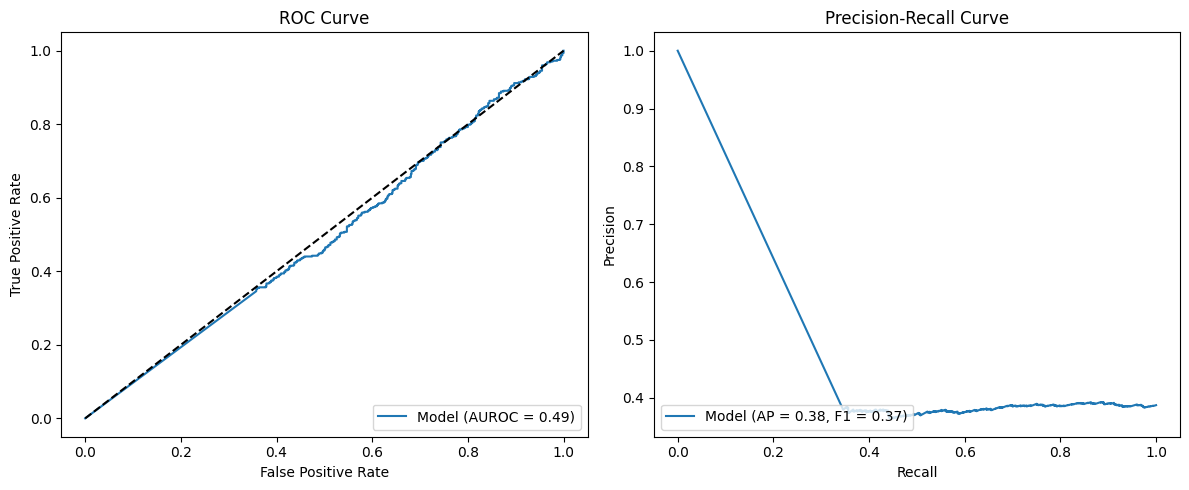

In [42]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt

prob_positive_class = predictions

fpr, tpr, _ = roc_curve(actual_labels, prob_positive_class)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(actual_labels, prob_positive_class)
ap = average_precision_score(actual_labels, prob_positive_class)

threshold = 0.9
binary_predictions = [1 if prob >= threshold else 0 for prob in prob_positive_class]

# Compute F1 score using binary predictions
f1 = f1_score(actual_labels, binary_predictions)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Model (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Model (AP = {ap:.2f}, F1 = {f1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()